In [1]:
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import ucimlrepo

import xgboost as xgb
import sklearn


In [2]:
# Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

adult = ucimlrepo.fetch_ucirepo(id=2)
# adult_df = pd.DataFrame(adult)
Counter(adult.data.targets['income'])


Counter({'<=50K': 24720, '<=50K.': 12435, '>50K': 7841, '>50K.': 3846})

In [3]:
adult.variables


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [4]:
adult.data.targets.describe()


,income
count,48842
unique,4
top,<=50K
freq,24720


In [5]:
adult.data.features.describe()


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Get the training and validation data

In [6]:
adult.variables


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [7]:
categorical = [col for col in adult.data.features.columns if adult.data.features[col].dtype == 'object']
numerical = [col for col in adult.data.features.columns if adult.data.features[col].dtype != 'object']

features = adult.data.features.copy()
targets = adult.data.targets.copy()

# Replace any nan categories with '?'
features[categorical] = features[categorical].fillna('?')
features[categorical] = features[categorical].astype('category')

# Create mapping for all features from category to a numerical value
categories = {
    cat: sorted(features[cat].unique()) for cat in categorical
}

# Add '?' to every catgory as 0 index
categories = {cat: lst if lst[0] == '?' else ['?'] + lst for cat, lst in categories.items()}

features_numeric = features.copy()

# Replace the categories with their index positions
for col in categorical:
    features_numeric[col] = features[col].apply(lambda x: categories[col].index(x))

validation_mask = targets['income'].str.endswith('.')
low_mask = targets['income'].str.startswith('<')

targets_numeric = targets.copy()

# Replace the targets with binary classes
targets_numeric['income'][low_mask] = 0
targets_numeric['income'][~low_mask] = 1
targets_numeric['income'] = targets_numeric['income'].astype(bool)


# We can always grab the necessary data by running XXX[validation_mask]

# train_features = features_numeric[~validation_mask]
# train_targets = targets_numeric[~validation_mask]
# valid_features = features_numeric[validation_mask]
# valid_targets = targets_numeric[validation_mask]


In [8]:
features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       48842 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      48842 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  48842 non-null  category
dtypes: category(8), int64(6)
memory usage: 2.6 MB


# Visualize the data

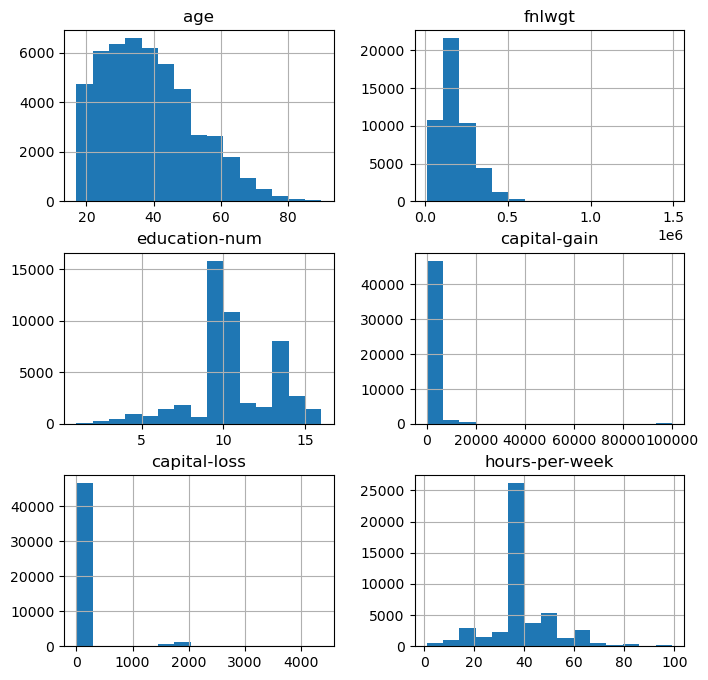

In [9]:
features_numeric.hist(bins=15, figsize=(8, 8));


array([[<Axes: title={'center': 'income'}>]], dtype=object)

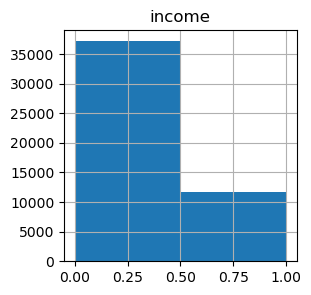

In [10]:
targets_numeric.astype(int).hist(bins=2, figsize=(3, 3))


# Make a GBDT model

In [11]:
params = {
    "model_params": {
        "n_estimators": 100,
        "max_depth": 4,
        "tree_method": "hist",
        "enable_categorical": True,
        'device': 'cuda',
        "eval_metric": [
            "logloss",
            "error",
            "auc",
            "aucpr",
            "map"
        ],
    },
    "train_params": {
        'verbose': False,
    }
}


clf = xgb.XGBClassifier(**params['model_params'])
clf.fit(features[~validation_mask], targets_numeric[~validation_mask],
        eval_set=[
            (features[~validation_mask], targets_numeric[~validation_mask]),
            (features[validation_mask], targets_numeric[validation_mask]),
        ],
        **params['train_params'],
       )
train_history = clf.evals_result()


[02:34:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181279512/work/src/learner.cc:767: 
Parameters: { "device" } are not used.



Text(0.5, 1.0, 'Training Performance')

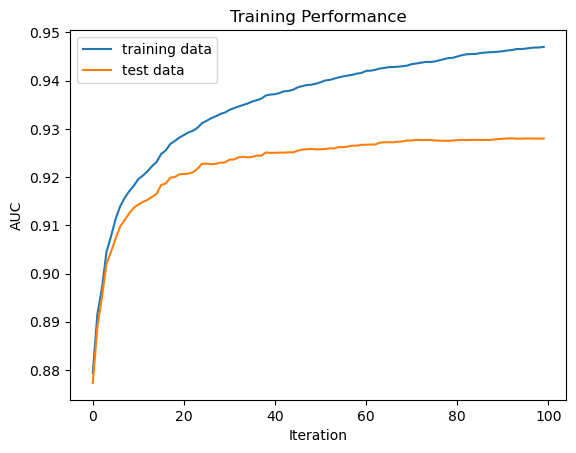

In [12]:
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["validation_0"]["auc"], label="training data")
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["validation_1"]["auc"], label="test data")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.title(f'Training Performance')


Text(0.5, 1.0, 'Training Performance')

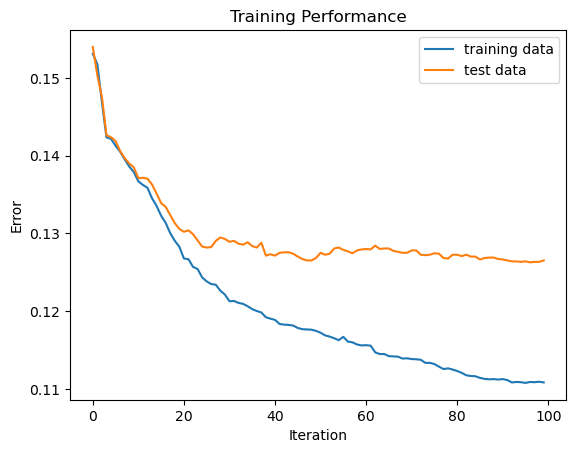

In [13]:
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["validation_0"]["error"], label="training data")
plt.plot(np.arange(params['model_params']['n_estimators']), train_history["validation_1"]["error"], label="test data")
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title(f'Training Performance')


Text(0.5, 1.0, 'ROC curve, AUC=(test: 0.9280, train: 0.9470)')

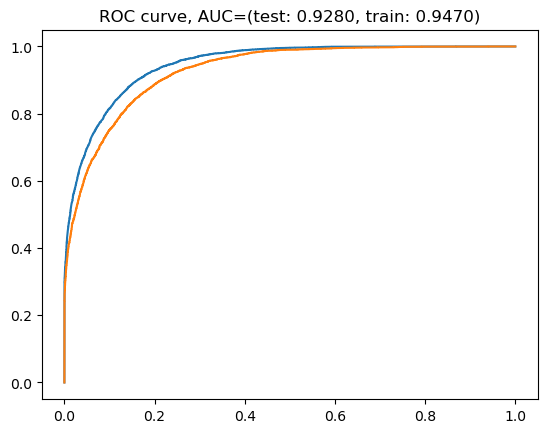

In [14]:
y_pred_proba_train = clf.predict_proba(features[~validation_mask])
y_pred_proba_valid = clf.predict_proba(features[validation_mask])

fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(targets_numeric[~validation_mask], y_pred_proba_train[:, 1])
fpr_valid, tpr_valid, _ = sklearn.metrics.roc_curve(targets_numeric[validation_mask], y_pred_proba_valid[:, 1])


auc_train = sklearn.metrics.auc(fpr_train, tpr_train)
auc_valid = sklearn.metrics.auc(fpr_valid, tpr_valid)

plt.plot(fpr_train, tpr_train, label="Training data")
plt.plot(fpr_valid, tpr_valid, label="Validation data")

plt.title(f"ROC curve, AUC=(test: {auc_valid:.4f}, train: {auc_train:.4f})")


# GBDT with all other datasets

In [15]:
import os
from pathlib import Path

from create_external_datasets import load_train_validation_test

DATASET_PATH = Path(os.path.abspath('third-party/tab-llm/datasets'))
dataset_names = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(DATASET_PATH / d)]
dataset_names

['creditg',
 'income',
 'diabetes',
 'calhousing',
 'blood',
 'heart',
 'car',
 'jungle',
 'bank']

In [16]:
def load_dataset(name):
    data = load_train_validation_test(name, DATASET_PATH / name)
    return data

def prepare_dataset(data, target_col_name='label'):
    r'''
    1. Changes the "object" types to "category"
    2. Splits all data into X, y pairs. y is the 'label' in the DataFrame
    3. ...
    4. Returns a copy of the data dict as well as two lists:
        - List of columns that are categorical
        - List of columns that are numerical
    '''
    result = {}
    categorical = []
    numerical = []
    for key, df in data.items():       
        categorical = [col for col in df.columns if df[col].dtype == 'object']
        numerical = [col for col in df.columns if df[col].dtype != 'object']

        df = df.copy()
        df[categorical] = df[categorical].astype('category')
        result[key] = df.loc[:, df.columns != target_col_name], df.loc[:, df.columns == target_col_name]
    return result, categorical, numerical

def train_gbdt(train_data, is_categorical=False, *, eval_data=None, init_kwargs=None, fit_kwargs=None):
    init_kwargs = init_kwargs or {}
    fit_kwargs = fit_kwargs or {}

    # Data
    if isinstance(train_data, pd.DataFrame):
        train_X = train_data.loc[:, train_data.columns != 'label']
        train_y = train_data.label
    else:
        train_X, train_y = train_data
    num_class = len(train_y['label'].unique())
    is_multiclass = num_class > 2

    # Default Args
    params = {
        "model_params": {
            "n_estimators": 500,
            "max_depth": 4,
            "tree_method": "hist" if is_categorical else 'approx',
            "enable_categorical": is_categorical,
            'objective': 'multi:softprob' if is_multiclass else 'binary:logistic',
            "eval_metric": [
                "mlogloss" if is_multiclass else 'logloss',
                "merror" if is_multiclass else 'error',
                "auc",
                "aucpr",
                # "map",
            ],
        },
        "fit_params": {
            'verbose': False,
            'eval_set': [(train_X, train_y)],
            # 'n_classes': num_class,
        }
    }

    # Updated args
    params['model_params'].update(init_kwargs)
    params['fit_params'].update(fit_kwargs)
    
    if eval_data is not None:
        if isinstance(eval_data, pd.DataFrame):
            eval_X = eval_data.loc[:, eval_data.columns != 'label']
            eval_y = eval_data.label
        else:
            eval_X, eval_y = eval_data

        params['fit_params']['eval_set'].append((eval_X, eval_y))

    # Model
    clf = xgb.XGBClassifier(**params['model_params'])
    clf.fit(train_X, train_y, **params['fit_params'])
    train_history = clf.evals_result()

    if is_multiclass:
        for key in train_history:
            train_history[key]['logloss'] = train_history[key]['mlogloss']
            train_history[key]['error'] = train_history[key]['merror']

    return clf, train_history
# categorical, numerical

In [17]:
def plot_metrics(model, history, train_data, eval_data):
    from matplotlib.patches import ConnectionPatch
    
    fig, ax = plt.subplots(2, 2, sharex='col', figsize=(8, 4.5))
    gs = ax[0, 1].get_gridspec()        

    # Left side
    num_iters = model.best_iteration + model.early_stopping_rounds + 1 if hasattr(model, 'best_iteration') else model.n_estimators
    num_iters = min(num_iters, model.n_estimators)
    best_iteration = model.best_iteration if hasattr(model, 'best_iteration') else model.n_estimators
    best_auc = history["validation_1"]["auc"][best_iteration]
    
    ax[0, 0].plot(np.arange(num_iters), history["validation_0"]["auc"], label="training data")
    ax[0, 0].plot(np.arange(num_iters), history["validation_1"]["auc"], label="test data")
    ax[0, 0].set_ylabel('AUC')
    ax[0, 0].set_title('Training Performance')
    if hasattr(model, 'best_iteration'):
        ax[0, 0].scatter([best_iteration], [best_auc], alpha=0.3)

    ax[1, 0].plot(np.arange(num_iters), history["validation_0"]["error"], label="training data")
    ax[1, 0].plot(np.arange(num_iters), history["validation_1"]["error"], label="test data")
    ax[1, 0].set_ylabel('Error')
    ax[1, 0].set_xlabel('Boosting Iteration')

    # Right side -- Combined axis
    ax[0, 1].remove()
    ax[1, 1].remove()
    axright = fig.add_subplot(gs[:, 1])

    y_pred_proba_train = model.predict_proba(train_data[0])
    y_pred_proba_valid = model.predict_proba(eval_data[0])

    y_train = train_data[1].to_numpy()
    y_valid = eval_data[1].to_numpy()
    num_classes = len(train_data[1].label.unique())
    if num_classes > 2:
        # RoC is not defined for multi-class -- use micro averaged OvR
        y_train = np.eye(num_classes)[y_train].ravel()
        y_pred_proba_train = y_pred_proba_train.ravel()
        y_valid = np.eye(num_classes)[y_valid].ravel()
        y_pred_proba_valid = y_pred_proba_valid.ravel()
    else:
        y_pred_proba_train = y_pred_proba_train[:, 1]
        y_pred_proba_valid = y_pred_proba_valid[:, 1]

    fpr_train, tpr_train, _ = sklearn.metrics.roc_curve(y_train, y_pred_proba_train)
    fpr_valid, tpr_valid, _ = sklearn.metrics.roc_curve(y_valid, y_pred_proba_valid)
    
    auc_train = sklearn.metrics.auc(fpr_train, tpr_train)
    auc_valid = sklearn.metrics.auc(fpr_valid, tpr_valid)
    
    axright.plot(fpr_train, tpr_train, label=f'Training data ({auc_train:.2%})')
    axright.plot(fpr_valid, tpr_valid, label=f'Validation data ({auc_valid:.2%})')
    axright.plot([0.0, 1.0], [0.0, 1.0], '--k', alpha=0.3)
    axright.legend(title='AUC')
    axright.set_xlabel('FPR')
    axright.set_ylabel('TPR')
    axright.set_title('Final Model (RoC)')

    for end_pos in ((0, 0), (0, 1)):
        cp = ConnectionPatch((best_iteration, best_auc), end_pos,
                             "data", "axes fraction",
                             axesA=ax[0, 0], axesB=axright,
                             color=[0, 0, 0, 0.3], linestyle='-.',
                             in_layout=False
                            )
        axright.add_artist(cp)
    
    return fig, ax, axright

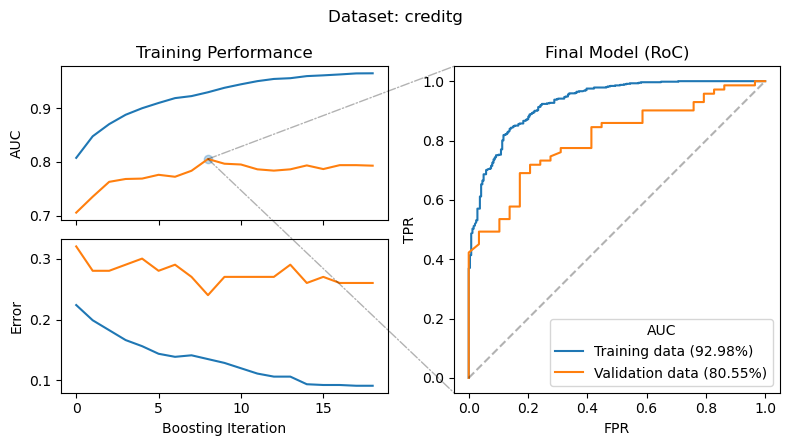

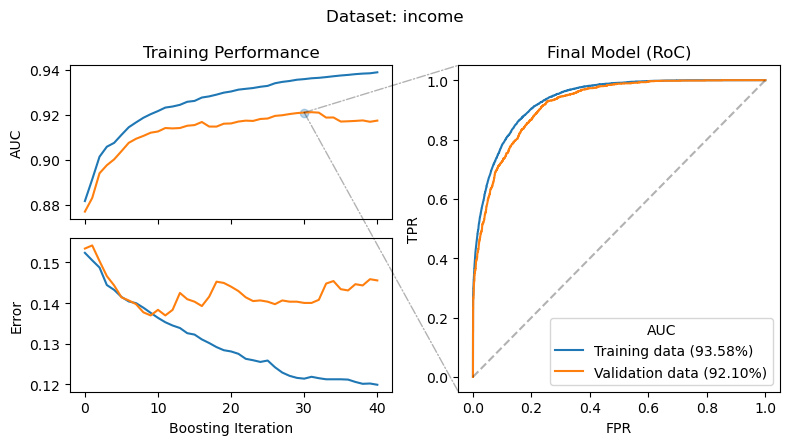

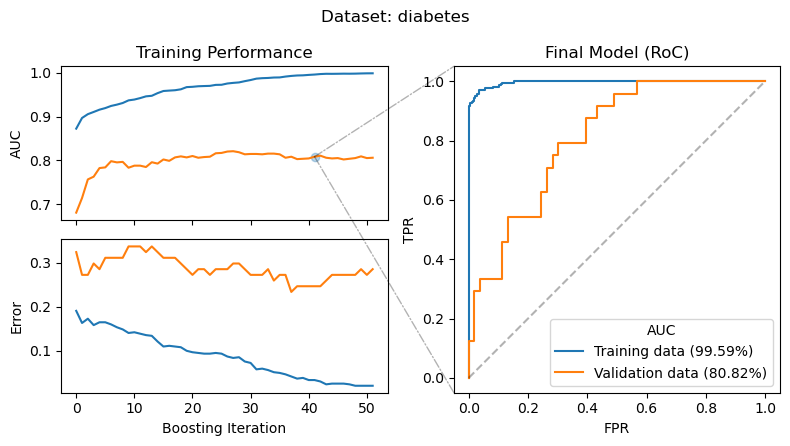

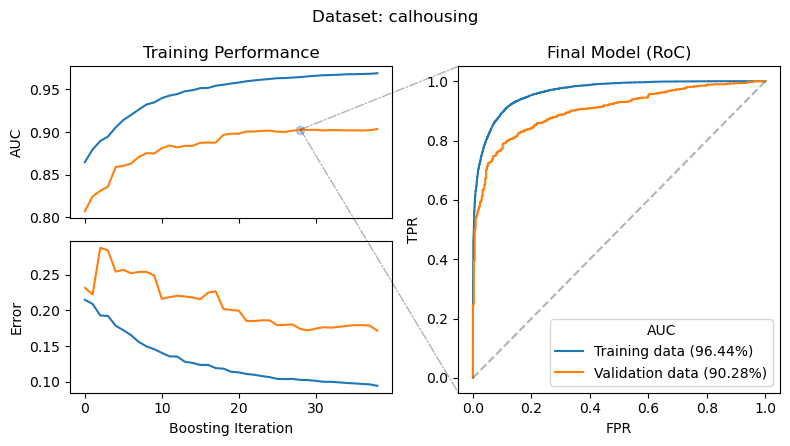

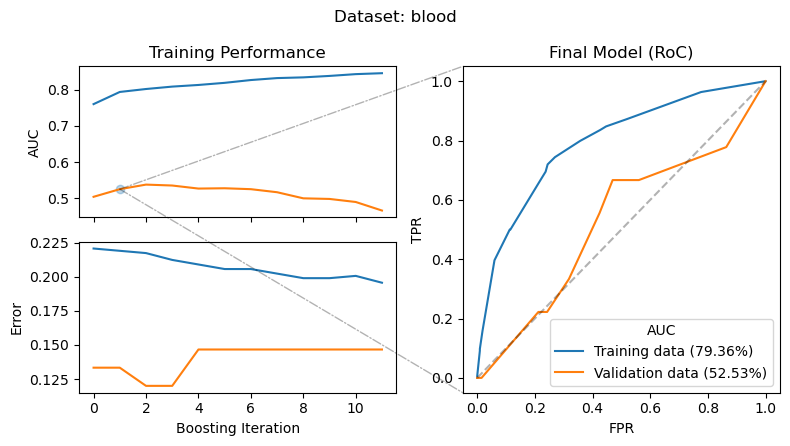

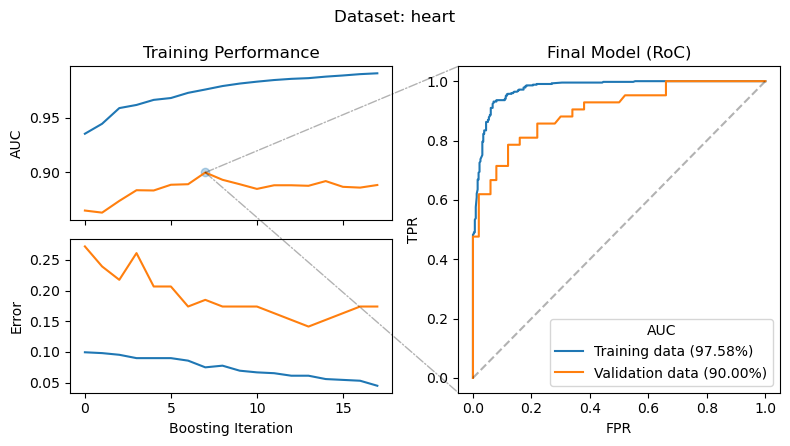

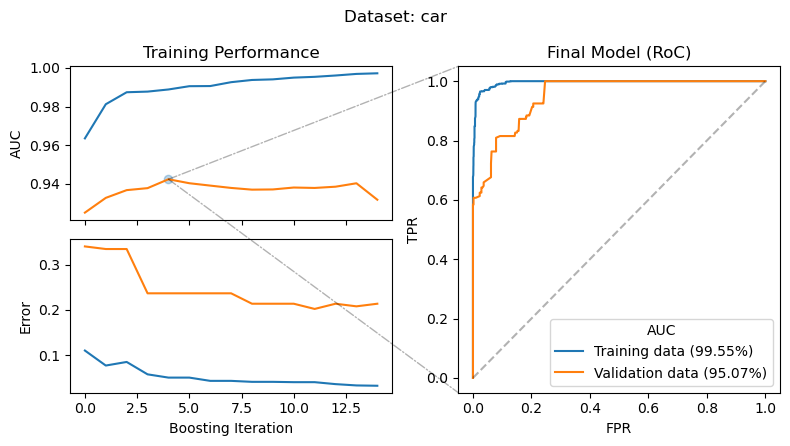

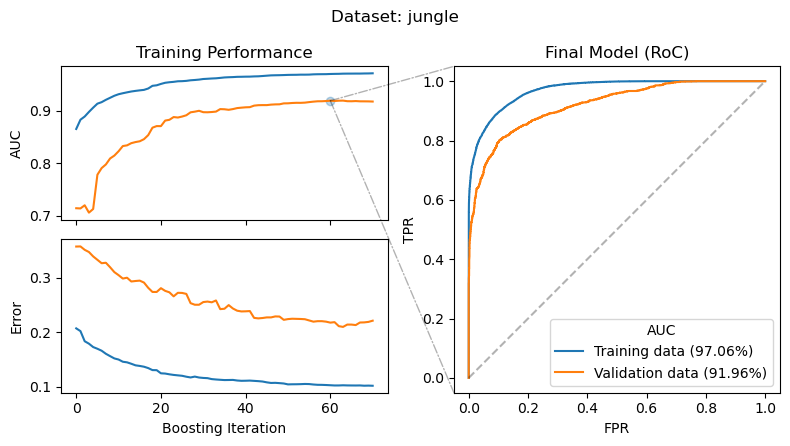

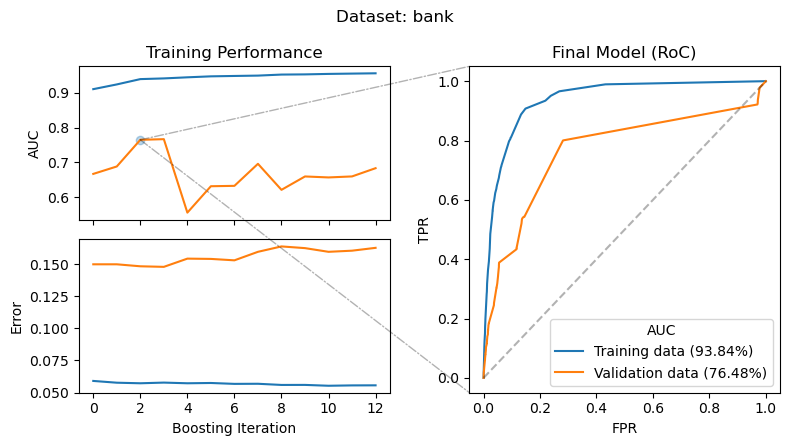

In [18]:
# Create plots
save_path = os.path.join('models/gbdt')
os.makedirs(save_path, exist_ok=True)
for name in dataset_names:
    # print(f'===> DEBUG: {name}')
    data = load_dataset(name)
    data_Xy, categorical, numerical = prepare_dataset(data)
    model, history = train_gbdt(data_Xy['train'], eval_data=data_Xy['validation'],
                                is_categorical=bool(len(categorical)),
                                init_kwargs={'early_stopping_rounds': 10})
    plot_metrics(model, history, data_Xy['train'], data_Xy['validation'])
    
    plt.suptitle(f'Dataset: {name}')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{name}_plot.png'))
    model.save_model(os.path.join(save_path, f'{name}_model.json'))